# Pancreas

In [1]:
import phlower
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pickle
from collections import Counter

In [2]:
adata = phlower.dataset.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Preprocessing and dimensonality reduction

In [3]:
adata.var_names_make_unique()

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.tl.pca(adata, svd_solver="arpack")
adata.obs['group'] = adata.obs['clusters']

## ddhodge

In [4]:
phlower.ext.ddhodge(adata, basis='X_pca', roots=list(adata.obs['group']=='Ductal'), k=4,npc=40, ndc=30,s=1)

2025-02-14 12:37:55.570603 distance_matrix
2025-02-14 12:37:56.428301 Diffusionmaps: 
done.
2025-02-14 12:38:00.917971 diffusion distance:
2025-02-14 12:38:02.066982 transition matrix:
2025-02-14 12:38:02.754823 graph from A
2025-02-14 12:38:02.797369 Rewiring: 
2025-02-14 12:38:02.797426 div(g_o)...
2025-02-14 12:38:08.124798 edge weight...
2025-02-14 12:38:08.363934 cholesky solve ax=b...
+ 1e-06 I is positive-definite
2025-02-14 12:38:09.316448 potential.
2025-02-14 12:38:23.174327 ddhodge done.
done.
2025-02-14 12:38:23.297023 calculate layouts
2025-02-14 12:39:48.192348 done


## Delaunay triangulation

In [5]:
phlower.tl.construct_delaunay(adata, trunc_quantile = 0.9,  start_n=10, end_n=10, separate_ends_triangle=True, circle_quant=0.7, calc_layout=False)

start clusters  ['Ngn3 high EP', 'Ductal', 'Beta', 'Epsilon', 'Alpha', 'Delta', 'Pre-endocrine', 'Ngn3 low EP']
end clusters  ['Ngn3 high EP', 'Ductal', 'Beta', 'Epsilon', 'Alpha', 'Delta', 'Pre-endocrine', 'Ngn3 low EP']


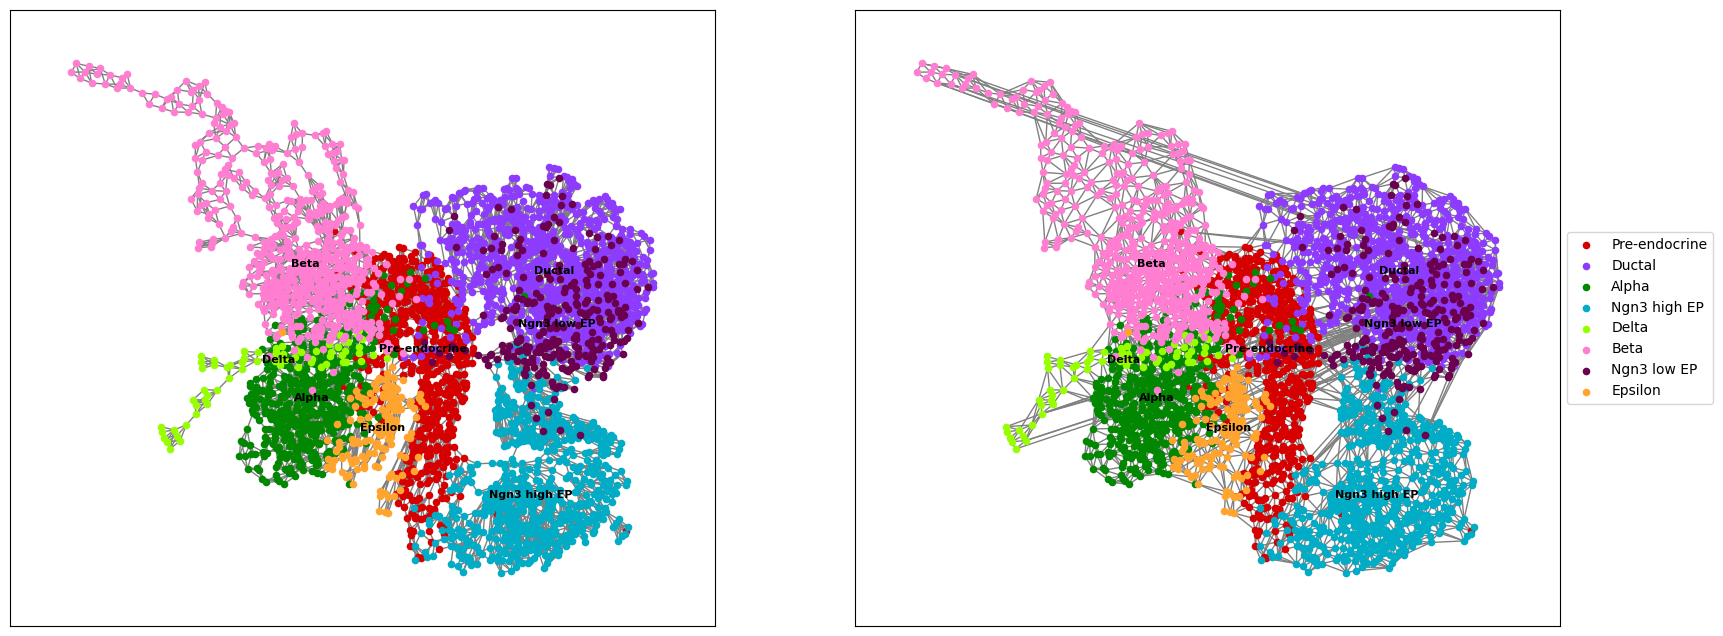

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
phlower.pl.nxdraw_group(adata, node_size=20, show_edges=True, ax=ax[0], show_legend=False, labelstyle='text', labelsize=8)
phlower.pl.nxdraw_group(adata, graph_name='X_pca_ddhodge_g_triangulation_circle', node_size=20, show_edges=True, ax=ax[1], show_legend=True, labelstyle='text', labelsize=8)

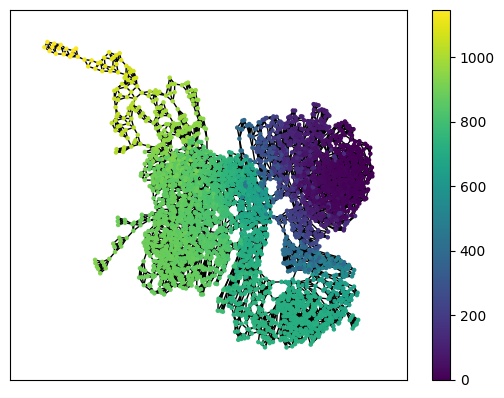

In [7]:
phlower.pl.nxdraw_score(adata, node_size=5)

## Hodge decomposition

In [8]:
from datetime import datetime 

dt1 = datetime.now() 
print('L1 Datetime Start:', dt1) 

phlower.tl.L1Norm_decomp(adata, L1_mode='sym', check_symmetric=False, isnorm = True) 
dt2 = datetime.now() 
print('L1 Datetime End:', dt2) 
delta = dt2 - dt1 
print('L1 Difference is:', delta) 

L1 Datetime Start: 2025-02-14 12:39:51.185159
9.136894941329956  sec
L1 Datetime End: 2025-02-14 12:40:00.567911
L1 Difference is: 0:00:09.382752


## determine harmonic

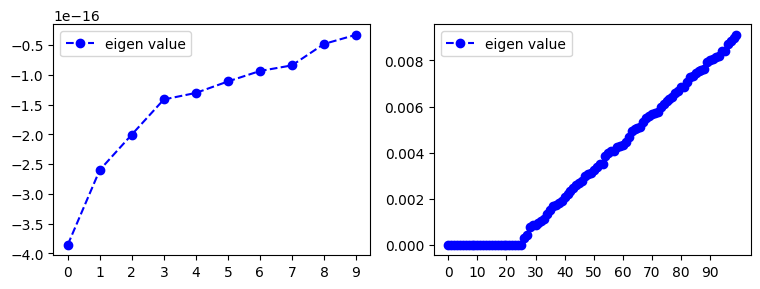

In [9]:
_, ax = plt.subplots(1,2, figsize=(9,3))
phlower.pl.plot_eigen_line(adata, n_eig=10,ax=ax[0])
phlower.pl.plot_eigen_line(adata, n_eig=100, step_size=10, ax=ax[1]) 

In [10]:
phlower.tl.knee_eigen(adata) 

knee eigen value is  26


## preference random walk

In [11]:
phlower.tl.random_climb_knn(adata, n=10000, roots_ratio=0.001, knn_edges_k=5)

100%|██████████| 10000/10000 [00:17<00:00, 573.46it/s]


## Project paths to harmonic space

In [12]:
phlower.tl.trajs_matrix(adata)

2025-02-14 12:40:33.820577 projecting trajectories to simplics...
2025-02-14 12:40:48.576892 Embedding trajectory harmonics...
eigen_n < 1, use knee_eigen to find the number of eigen vectors to use: 26


/home/sz753404/miniconda3/envs/R422/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2025-02-14 12:41:23.889403 done.


## Paths clustering

In [13]:
phlower.tl.trajs_clustering(adata, clustering_method='leiden', resolution=1.5, oname_basis='') 

calcaulating distances...
leiden clustering...


In [14]:
phlower.tl.select_trajectory_clusters(adata, verbose=False)

/home/sz753404/miniconda3/envs/R422/lib/python3.10/site-packages/phlower/tools/trajectory.py:436: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = scipy.stats.skew(l)


In [15]:
phlower.tl.unique_trajectory_clusters(adata, verbose=False)

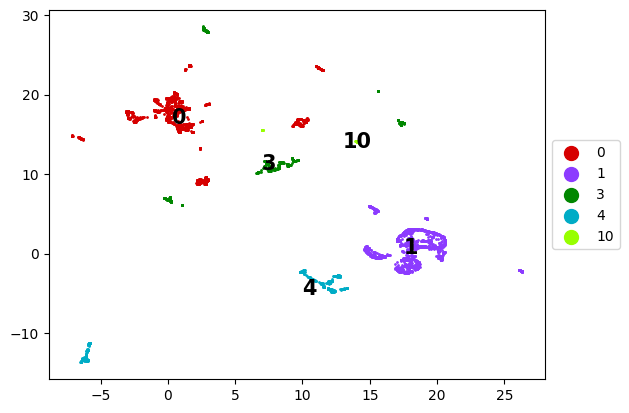

In [16]:
phlower.pl.plot_trajs_embedding(adata, clusters="trajs_clusters") 

z_min, z_max 2.551998446841963e-09 2.342906917185627e-06


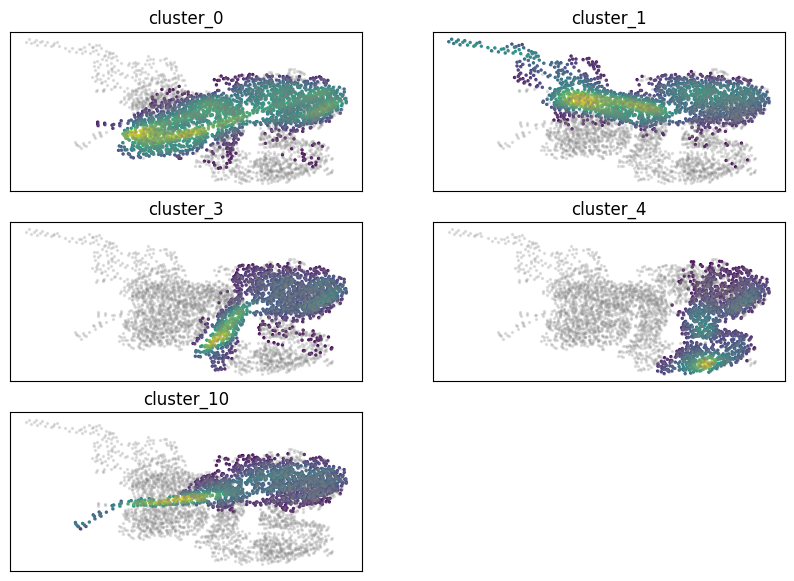

In [17]:
fig, ax = phlower.pl.plot_density_grid(adata,  figsize=(10, 7), cluster_name='trajs_clusters', bg_alpha=0.2, return_fig=True)

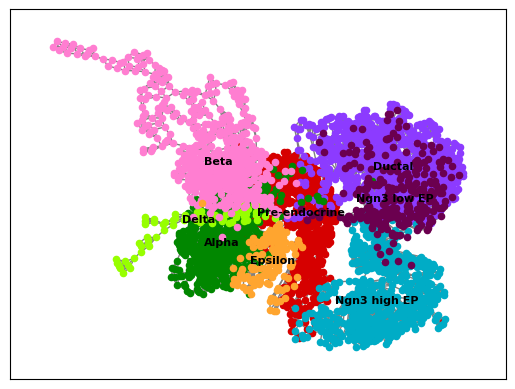

In [18]:
phlower.pl.nxdraw_group(adata, node_size=20, show_edges=True, show_legend=False, labelstyle='text', labelsize=8)

## Tree creating

In [19]:
phlower.tl.harmonic_stream_tree(adata, min_bin_number=30, retain_clusters=[0,1,3,10],trim_end=True,verbose=True)

2025-02-14 12:44:18.608951 trajectory groups ranking...
eigen_n < 1, use knee_eigen to find the number of eigen vectors to use
eigen_n: 26
[0, 1, 3, 10]


traj bins: 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]


2025-02-14 12:44:34.646005 sync bins to by pseudo time...
2025-02-14 12:44:35.068413 calculating distances between bin pairs...
2025-02-14 12:44:35.481963 fate tree creating...
[(0, 1, 10, 3)]
2025-02-14 12:44:35.482928 tree attributes adding...
del 6_31
del 6_30
del 6_28
del 5_34
2025-02-14 12:44:36.197103 plugin to STREAM...
2025-02-14 12:44:36.206856 projecting trajs to harmonic...
2025-02-14 12:44:37.467089 cumsum...
2025-02-14 12:44:38.009291 edge cumsum dict...


edges projection: 100%|██████████| 5186/5186 [00:06<00:00, 784.35it/s]


2025-02-14 12:44:45.807129 done...
there are 56 nodes not visited in the tree
will approximate the node cumsum coordinate by 5 nearest accessible neighbors
2025-02-14 12:44:50.694360 done...


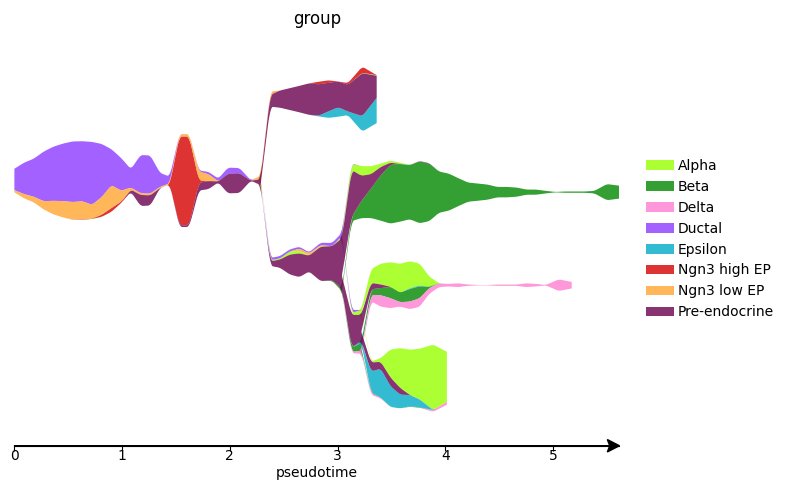

In [20]:
phlower.ext.plot_stream(adata, fig_size=(8,5), dist_scale=1, log_scale=True, factor_min_win=1, factor_num_win=5, show_legend=True)

In [21]:
pickle.dump(adata, open("pancreas_phlower.pickle", 'wb'))

In [22]:
import session_info
session_info.show()